## 📄 Dataset Description

This dataset captures the structure, style, and goals of personalized workout programs. It includes key attributes such as program length, time per workout, goal type, equipment used, fitness level, and total number of exercises. The dataset is designed to help analyze patterns in workout preferences and to build machine learning models that predict fitness goals or recommend programs based on user needs.



### Column Descriptions

| Column Name       | Description                                                              |
| :---------------- | :----------------------------------------------------------------------- |
| `Program_Length`  | Total length of the workout program (in weeks).                          |
| `Time_Per_Workout`| Average time spent per workout session (in minutes).                     |
| `Level`           | User experience level (Beginner, Intermediate, Advanced).                |
| `Goal`            | Main fitness goal (Fat Loss, Muscle Gain, Endurance, Flexibility).       |
| `Equipment`       | Type of equipment required (Bodyweight, Dumbbells, Resistance Bands, etc.).|
| `Total_Exercises` | Number of different exercises included in the workout plan.              |

In [133]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import ast
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(42)

In [134]:
df = pd.read_csv('../data/fitness_and_workout_dataset.csv')

In [135]:
df.head()

,title,description,level,goal,equipment,program_length,time_per_workout,total_exercises,created,last_edit
0,(MASS MONSTER) High Intensity 4 Day Upper Lowe...,Build tones of muscular with this high intensi...,['Intermediate'],"['Muscle & Sculpting', 'Bodyweight Fitness']",Full Gym,12.0,90.0,384,2024-01-20 10:23:00,2025-06-29 12:39:00
1,(NOT MY PROGRAM)SHJ Jotaro,Build strength and size,"['Advanced', 'Intermediate']",['Bodybuilding'],Full Gym,8.0,60.0,224,2024-07-08 02:28:00,2025-06-18 09:15:00
2,1 PowerLift Per Day Powerbuilding 5 Day Bro Split,Based off of Andy Baker's KCS (Kingwood Streng...,"['Beginner', 'Novice', 'Intermediate']","['Athletics', 'Powerlifting', 'Powerbuilding']",Full Gym,6.0,90.0,237,2025-04-23 09:21:00,2025-06-18 11:55:00
3,10 Week Mass Building Program,This workout is designed to increase your musc...,"['Intermediate', 'Advanced']",['Powerbuilding'],Garage Gym,10.0,70.0,280,2024-09-07 03:44:00,2025-06-18 08:01:00
4,10 week deadlift focus,Increase deadlift,"['Intermediate', 'Advanced']","['Powerbuilding', 'Powerlifting', 'Bodybuildin...",Full Gym,10.0,80.0,356,2024-12-23 03:13:00,2025-06-18 12:19:00


## 📃 EDA (Exploratory Data Analysis)

### 1. Basic Understanding of Dataset

In [136]:
print('Shape dataset:', df.shape)

Shape dataset: (2598, 10)


In [137]:
print('Info dataset:')
df.info()

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2598 entries, 0 to 2597
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             2598 non-null   object 
 1   description       2594 non-null   object 
 2   level             2598 non-null   object 
 3   goal              2598 non-null   object 
 4   equipment         2597 non-null   object 
 5   program_length    2597 non-null   float64
 6   time_per_workout  2598 non-null   float64
 7   total_exercises   2598 non-null   int64  
 8   created           2597 non-null   object 
 9   last_edit         2596 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 203.1+ KB


In [138]:
# Statistik deskriptif
df.describe().round()

,program_length,time_per_workout,total_exercises
count,2597.0,2598.0,2598.0
mean,9.0,69.0,233.0
std,4.0,24.0,208.0
min,1.0,10.0,1.0
25%,5.0,60.0,108.0
50%,8.0,60.0,192.0
75%,12.0,90.0,308.0
max,18.0,180.0,5040.0


In [139]:
df.describe(include=['O'])

,title,description,level,goal,equipment,created,last_edit
count,2598,2594,2598,2598,2597,2597,2596
unique,2598,2494,44,179,4,2585,605
top,🥷🥷🥷,Hypertrophy,['Intermediate'],['Bodybuilding'],Full Gym,2024-12-09 07:15:00,2025-06-18 07:49:00
freq,1,11,622,574,1848,2,16


In [140]:
# Check missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 title               0
description         4
level               0
goal                0
equipment           1
program_length      1
time_per_workout    0
total_exercises     0
created             1
last_edit           2
dtype: int64


There are 5 columns are missing values:
- description
- equipment
- program_length
- created
- last_edit


In [141]:
df.dropna(inplace=True)

In [142]:
df.isnull().sum()

title               0
description         0
level               0
goal                0
equipment           0
program_length      0
time_per_workout    0
total_exercises     0
created             0
last_edit           0
dtype: int64

In [143]:
print(f'Duplicate rows: {df.duplicated().sum()}')

Duplicate rows: 0


### 2. Analysis of Important Columns

In [144]:
level_list = df['level'].apply(ast.literal_eval)
goal_list = df['goal'].apply(ast.literal_eval)
all_extracted_words_levels = [word for sublist in level_list for word in sublist]
all_extracted_words_goals = [word for sublist in goal_list for word in sublist]

print("Unique difficulty levels:", list(set(all_extracted_words_levels)))
print(f"Range duration: {df['time_per_workout'].min()} - {df['time_per_workout'].max()} minutes")
print(f"Goal: {list(set(all_extracted_words_goals))} unique values")
print(f'Equipment: {df["equipment"].unique()} unique values')


Unique difficulty levels: ['Intermediate', 'Advanced', 'Novice', 'Beginner']
Range duration: 10.0 - 180.0 minutes
Goal: ['Athletics', 'Bodyweight Fitness', 'Bodybuilding', 'Powerbuilding', 'Powerlifting', 'Olympic Weightlifting', 'Muscle & Sculpting'] unique values
Equipment: ['Full Gym' 'Garage Gym' 'At Home' 'Dumbbell Only'] unique values


### 3. Analysis Numeric Columns

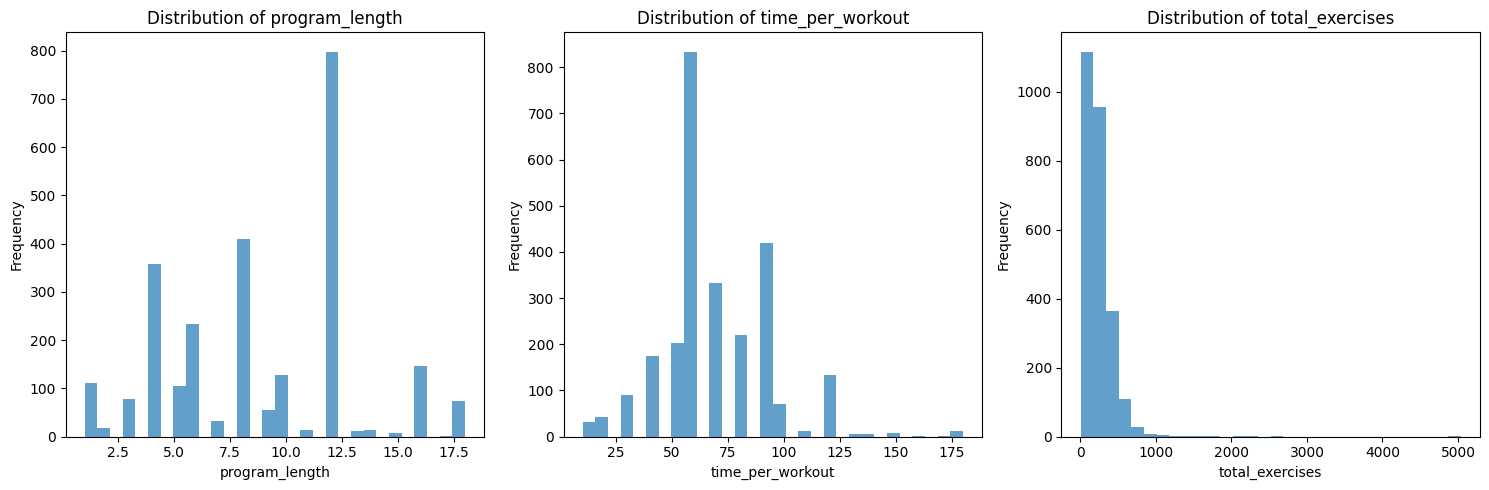

In [145]:
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

# Visualization distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(numeric_columns):
    axes[i].hist(df[col], bins=30, alpha=0.7)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

### 4. Analysis Object Columns

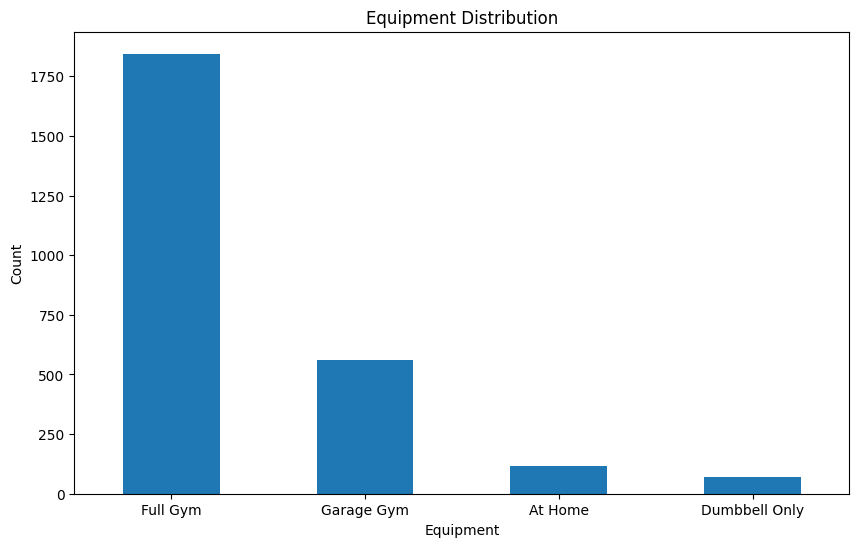

In [146]:
# Equipment visualization

df['equipment'].value_counts().plot(kind='bar', figsize=(10, 6))
plt.title('Equipment Distribution')
plt.xlabel('Equipment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

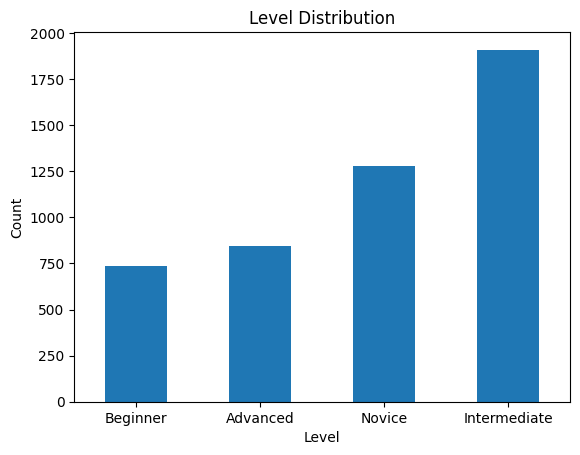

In [147]:

level_series = pd.Series(dict(Counter(all_extracted_words_levels)))

level_series.sort_values(ascending=True).plot(kind='bar')
plt.title('Level Distribution')
plt.xlabel('Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

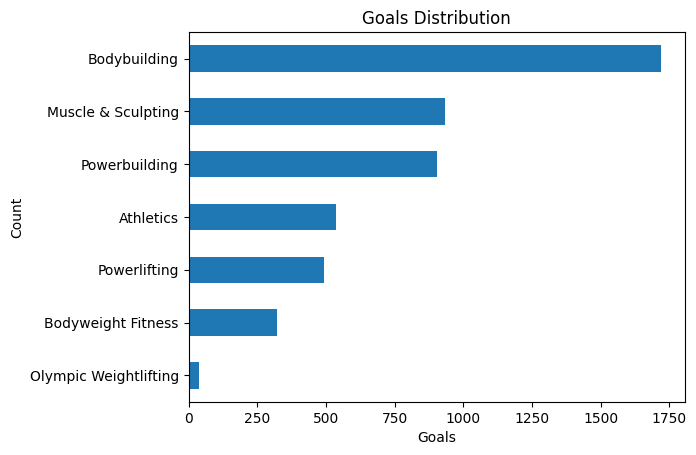

In [148]:
goals_series = pd.Series(dict(Counter(all_extracted_words_goals)))

goals_series.sort_values(ascending=True).plot(kind='barh')
plt.title('Goals Distribution')
plt.xlabel('Goals')
plt.ylabel('Count')
# plt.xticks(rotation=)
plt.show()

## 🤖 Make System Recommendation

### 1. Content-Based Recommendation with Cosine Similarity

In [149]:
df_model = df.copy()

# Preprocessing untuk kolom level dan goal (ambil yang pertama dari list)
def extract_first_value(text):
    if pd.isna(text):
        return 'Unknown'
    # Parse string list dan ambil nilai pertama
    try:
        values = ast.literal_eval(text)
        return values[0] if values else 'Unknown'
    except:
        return 'Unknown'

df_model['primary_level'] = df_model['level'].apply(extract_first_value)
df_model['primary_goal'] = df_model['goal'].apply(extract_first_value)

In [150]:
def create_content_features(df):
    # Combine categorical features to be text
    df_model['context_text'] = (df_model['primary_level'] + ' ' + 
                                df_model['primary_goal'] + ' ' +
                                df_model['equipment'])
    
    # TF-IDF vectorization for text features
    tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
    content_matrix = tfidf.fit_transform(df_model['context_text'])
    
    # Normalize numeric features
    scaler = StandardScaler()
    numeric_features = ['program_length', 'time_per_workout', 'total_exercises']
    numeric_scaled = scaler.fit_transform(df_model[numeric_features])
    
    return content_matrix, numeric_scaled, tfidf, scaler

# Create content features
content_matrix, numeric_scaled, tfidf, scaler = create_content_features(df_model)

print(f'Content matrix shape: {content_matrix.shape}')
print(f'Numeric features shape: {numeric_scaled.shape}')

Content matrix shape: (2592, 19)
Numeric features shape: (2592, 3)


### 2. Recommendation Function

In [151]:
def recommend_workouts_improved(target_idx, df, content_matrix, numeric_scaled, 
                                top_k=5, content_weight=0.7, numeric_weight=0.3):
    """
    Give recommendation workout with hybrid approach
    """
    
    # Content-based similarity menggunakan cosine similarity
    content_sim = cosine_similarity(content_matrix[target_idx], content_matrix).flatten()
    
    # Numeric similarity using inverse euclidean distance
    target_numeric = numeric_scaled[target_idx].reshape(1, -1)
    numeric_distances = np.linalg.norm(numeric_scaled - target_numeric, axis=1)
    numeric_sim = 1 / (1 + numeric_distances) # Convert distance to similarity
    
    # Combine similarity score
    combined_sim = content_weight * content_sim + numeric_weight * numeric_sim 
    
    # Exclude target workout itself
    combined_sim[target_idx] = -1 
    
    # Get top-k recommendations
    top_indices = combined_sim.argsort()[-top_k:][::-1]
    top_scores = combined_sim[top_indices]
    
    return top_indices, top_scores

# Tes recommendation
target_idx = 0
recommendation, scores = recommend_workouts_improved(
    target_idx, df_model, content_matrix, numeric_scaled, top_k=5
)

In [154]:
print(f'Target workout: {df_model.iloc[target_idx]["title"]}')
print(f'Level: {df_model.iloc[target_idx]["primary_level"]}')
print(f'Goal: {df_model.iloc[target_idx]["primary_goal"]}')
print(f'Equipment: {df_model.iloc[target_idx]["equipment"]}')
print(f'Duration: {df_model.iloc[target_idx]["time_per_workout"]:.0f} minutes')
print(f'Program length: {df_model.iloc[target_idx]["program_length"]:.0f} weeks')

print("="*60)
print("Top Recommendations")
print("="*60)

for i, (idx, score) in enumerate(zip(recommendation, scores), 1):
    print(f'{i}. {df_model.iloc[idx]["title"]}')
    print(f'   Level: {df_model.iloc[idx]["primary_level"]}')
    print(f'   Goal: {df_model.iloc[idx]["primary_goal"]}')
    print(f'   Equipment: {df_model.iloc[idx]["equipment"]}')
    print(f'   Duration: {df_model.iloc[idx]["time_per_workout"]:.0f} minutes')
    print(f'   Program length: {df_model.iloc[idx]["program_length"]:.0f} weeks')
  

Target workout: (MASS MONSTER) High Intensity 4 Day Upper Lower Program
Level: Intermediate
Goal: Muscle & Sculpting
Equipment: Full Gym
Duration: 90 minutes
Program length: 12 weeks
Top Recommendations
1. 12 Weeks Bikini Comp Ready
   Level: Intermediate
   Goal: Muscle & Sculpting
   Equipment: Full Gym
   Duration: 90 minutes
   Program length: 12 weeks
2. Tiger Killer - Orochi Doppo
   Level: Intermediate
   Goal: Muscle & Sculpting
   Equipment: Full Gym
   Duration: 80 minutes
   Program length: 12 weeks
3. 5 Day Strongbuilding
   Level: Intermediate
   Goal: Muscle & Sculpting
   Equipment: Full Gym
   Duration: 90 minutes
   Program length: 12 weeks
4. Ben’s Plan
   Level: Intermediate
   Goal: Muscle & Sculpting
   Equipment: Full Gym
   Duration: 90 minutes
   Program length: 12 weeks
5. Transforma tus glúteos 2
   Level: Intermediate
   Goal: Muscle & Sculpting
   Equipment: Full Gym
   Duration: 80 minutes
   Program length: 12 weeks


### 3. Evaluation and Visualization

Recommendation analysis for: (MASS MONSTER) High Intensity 4 Day Upper Lower Program
Level matches: 5/5
Goal matches: 5/5
Equipment matches: 5/5


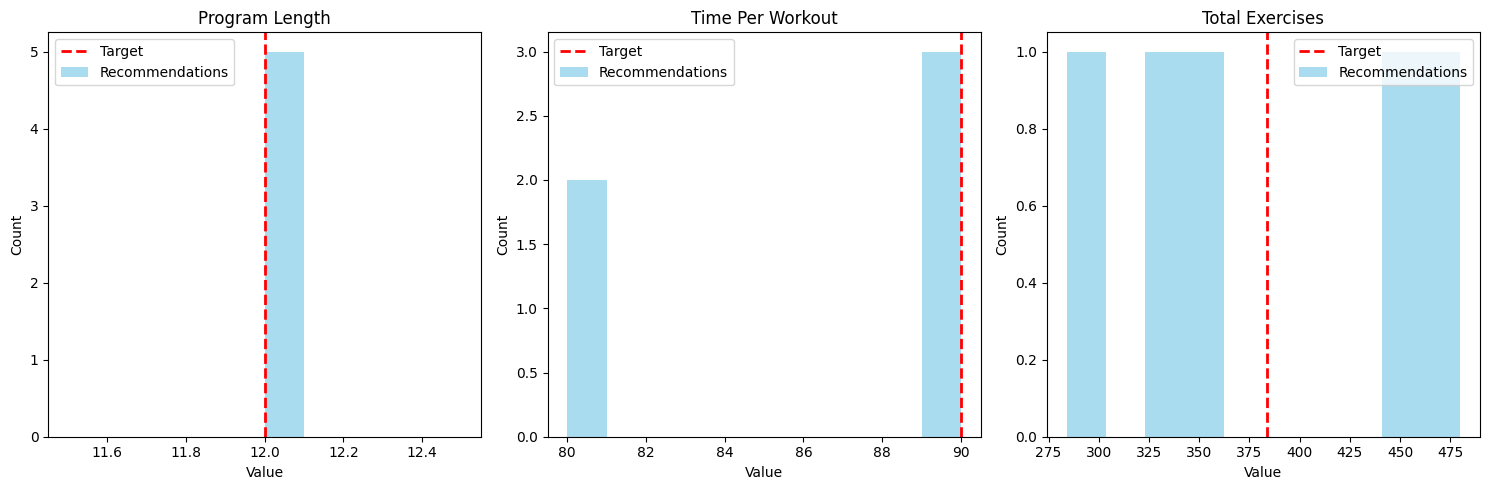

In [155]:
def analyze_recommendation(target_idx, recommendations, df):
    """ 
    Analyze quality of recommendations
    """
    target = df_model.iloc[target_idx]
    recommended_workouts = df_model.iloc[recommendations]
    
    # Analyze similarity based on category
    level_match = (recommended_workouts['primary_level'] == target['primary_level']).sum()
    goal_match = (recommended_workouts['primary_goal'] == target['primary_goal']).sum()
    equipment_match = (recommended_workouts['equipment'] == target['equipment']).sum()
    
    print(f'Recommendation analysis for: {target["title"]}')
    print(f"Level matches: {level_match}/{len(recommendations)}")
    print(f"Goal matches: {goal_match}/{len(recommendations)}")
    print(f"Equipment matches: {equipment_match}/{len(recommendations)}")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    numeric_cols = ['program_length', 'time_per_workout', 'total_exercises']
    for i, col in enumerate(numeric_cols):
        target_val = target[col]
        rec_vals = recommended_workouts[col]
        
        axes[i].axvline(target_val, color='red', linestyle='--', label='Target', linewidth=2)
        axes[i].hist(rec_vals, bins=10, alpha=0.7, color='skyblue', label='Recommendations')
        axes[i].set_title(f'{col.replace("_", " ").title()}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Count')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    return level_match, goal_match, equipment_match


level_match, goal_match, equipment_match = analyze_recommendation(target_idx, recommendation, df_model)


### 4. Interactive Recommendation System

In [157]:
def interactive_recommendation_system(df, content_matrix, numeric_scaled):

    print("=== FITNESS WORKOUT RECOMMENDATION SYSTEM ===\n")
    
    # Tampilkan beberapa workout untuk dipilih
    print("Available Workouts (sample):")
    sample_indices = np.random.choice(len(df), 10, replace=False)
    
    for i, idx in enumerate(sample_indices):
        print(f"{i+1}. {df.iloc[idx]['title'][:50]}...")
        print(f"   Level: {df.iloc[idx]['primary_level']} | Goal: {df.iloc[idx]['primary_goal']}")
        print(f"   Equipment: {df.iloc[idx]['equipment']} | Duration: {df.iloc[idx]['time_per_workout']:.0f}min")
        print()
    
    # User input
    try:
        choice = int(input("Choose a workout (1-10): ")) - 1
        target_idx = sample_indices[choice]
        
        print(f"\nYou selected: {df.iloc[target_idx]['title']}")
        
        # Generate recommendations
        recommendations, scores = recommend_workouts_improved(
            target_idx, df, content_matrix, numeric_scaled, top_k=5
        )
        
        print("\n" + "="*60)
        print("RECOMMENDATIONS FOR YOU:")
        print("="*60)
        
        for i, (idx, score) in enumerate(zip(recommendations, scores), 1):
            print(f"\n{i}. {df.iloc[idx]['title']}")
            print(f"   Match Score: {score:.1%}")
            print(f"   Level: {df.iloc[idx]['primary_level']}")
            print(f"   Goal: {df.iloc[idx]['primary_goal']}")
            print(f"   Equipment: {df.iloc[idx]['equipment']}")
            print(f"   Duration: {df.iloc[idx]['time_per_workout']:.0f} minutes")
        
    except (ValueError, IndexError):
        print("Invalid choice. Please try again.")

# Jalankan sistem interaktif
interactive_recommendation_system(df_model, content_matrix, numeric_scaled)

=== FITNESS WORKOUT RECOMMENDATION SYSTEM ===

Available Workouts (sample):
1. LazyGainz (Dylan’s lifts)...
   Level: Beginner | Goal: Bodybuilding
   Equipment: Full Gym | Duration: 60min

2. 3-Day Full Body(BB, DL, Squat)...
   Level: Novice | Goal: Athletics
   Equipment: Full Gym | Duration: 60min

3. Ash’s Shredded Bod...
   Level: Advanced | Goal: Bodybuilding
   Equipment: Garage Gym | Duration: 30min

4. Nuckols Stronger by Science Bench 3x Advanced...
   Level: Intermediate | Goal: Bodybuilding
   Equipment: Full Gym | Duration: 60min

5. Asians assemble...
   Level: Beginner | Goal: Bodyweight Fitness
   Equipment: At Home | Duration: 30min

6. 4 days full body with weak knees...
   Level: Intermediate | Goal: Bodybuilding
   Equipment: Full Gym | Duration: 60min

7. Private program for myself...
   Level: Intermediate | Goal: Bodybuilding
   Equipment: Full Gym | Duration: 70min

8. X-Athlean GYM machine supersets...
   Level: Beginner | Goal: Bodyweight Fitness
   Equipment


You selected: LazyGainz (Dylan’s lifts)

RECOMMENDATIONS FOR YOU:

1. Kettlebuilding Calisthenics
   Match Score: 95.2%
   Level: Beginner
   Goal: Bodybuilding
   Equipment: Full Gym
   Duration: 60 minutes

2. Physical 100 Workout Program (4 Day Upper Lower)
   Match Score: 93.6%
   Level: Beginner
   Goal: Bodybuilding
   Equipment: Full Gym
   Duration: 60 minutes

3. ABABAB
   Match Score: 92.3%
   Level: Beginner
   Goal: Bodybuilding
   Equipment: Full Gym
   Duration: 60 minutes

4. Train Like Arnold
   Match Score: 92.3%
   Level: Beginner
   Goal: Bodybuilding
   Equipment: Full Gym
   Duration: 60 minutes

5. Peak Male Performance
   Match Score: 91.1%
   Level: Beginner
   Goal: Bodybuilding
   Equipment: Full Gym
   Duration: 60 minutes


### 5. Evaluation Performance of System

In [158]:
def evaluate_recommendation_system(df, content_matrix, numeric_scaled, n_tests=100):
    results = {
        'level_accuracy': [],
        'goal_accuracy': [],
        'equipment_accuracy': [],
        'avg_similarity': []
    }
    
    test_indices = np.random.choice(len(df), n_tests, replace=False)
    
    for target_idx in test_indices:
        recommendations, scores = recommend_workouts_improved(
            target_idx, df, content_matrix, numeric_scaled, top_k=5
        )
        
        target = df.iloc[target_idx]
        recommended = df.iloc[recommendations]
        
        # Calculate accuracies
        level_acc = (recommended['primary_level'] == target['primary_level']).mean()
        goal_acc = (recommended['primary_goal'] == target['primary_goal']).mean()
        equipment_acc = (recommended['equipment'] == target['equipment']).mean()
        avg_sim = scores.mean()
        
        results['level_accuracy'].append(level_acc)
        results['goal_accuracy'].append(goal_acc)
        results['equipment_accuracy'].append(equipment_acc)
        results['avg_similarity'].append(avg_sim)
        
    print("=== Recommendation System Evaluation ===")
    print(f'Tests performed: {n_tests}')
    print(f'Average level match: {np.mean(results["level_accuracy"]):.1%}')
    print(f'Average goal match: {np.mean(results["goal_accuracy"]):.1%}')
    print(f'Average equipment match: {np.mean(results["equipment_accuracy"]):.1%}')
    print(f'Average similarity score: {np.mean(results["avg_similarity"]):.3f}')
    
    return results 


# Evaluation system
evaluation_results = evaluate_recommendation_system(df_model, content_matrix, numeric_scaled)

=== Recommendation System Evaluation ===
Tests performed: 100
Average level match: 97.6%
Average goal match: 99.4%
Average equipment match: 98.6%
Average similarity score: 0.903
